# Single label Classifier - AF Detection

Using the dataset provided by the 2020 Physionet Challenge we've developed an Atrial Fibrilation Detector trained to identify AF diagnosed patients from a dataset containing patients with different pathologies like: PAC, RBBB, I-AVB, PVC, LBBB, STD, STE and healthy individuals.

Although data from 12-lead ECG was provided, for this first analysis we've only used the lead 2 data and we've processed the signals in order to create a dataframe consisting of features we believe will help us classify.


In [1]:
import sys
import os

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from IPython.display import display

from scipy.cluster import hierarchy as hc
from sklearn import metrics
from sklearn.metrics import f1_score, fbeta_score, make_scorer, confusion_matrix
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE

import mlflow
import mlflow.sklearn

%matplotlib inline
import plotly.express as px
import seaborn as sns

## Now we can choose which lead data to load

### Lead 2 data seems to give better results:

In [2]:
lead = 'HRV-lead2'
df_raw = pd.read_feather('datasets/phys-raw-lead2-HRV-corrected')
df_raw.columns

Index(['HRV_RMSSD', 'HRV_MeanNN', 'HRV_SDNN', 'HRV_SDSD', 'HRV_CVNN',
       'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN', 'HRV_IQRNN',
       'HRV_pNN50', 'HRV_pNN20', 'HRV_TINN', 'HRV_HTI', 'mean_P_Peaks', 'age',
       'label'],
      dtype='object')

In [3]:
labels = pd.get_dummies(df_raw['label'])
labels.describe()

AF        I-AVB         LBBB       Normal          PAC  \
count  6877.000000  6877.000000  6877.000000  6877.000000  6877.000000   
mean      0.177548     0.104988     0.028937     0.133488     0.079104   
std       0.382160     0.306560     0.167642     0.340127     0.269921   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

               PVC         RBBB          STD          STE  
count  6877.000000  6877.000000  6877.000000  6877.000000  
mean      0.091173     0.243566     0.114294     0.026901  
std       0.287877     0.429265     0.318191     0.161807  
min       0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000     0.000000  
75%       0.000000     0.000000     0.000000     0.000000  
max       1.000000     1.000000     1.000000     1.000000

In [4]:
df_raw = df_raw.loc[df_raw['age'] >= 0]

## Removing Redundant Features

By calculating a Dendrogram we look for features that may be providing the same information so we can remove them and end up with a cleaner model.

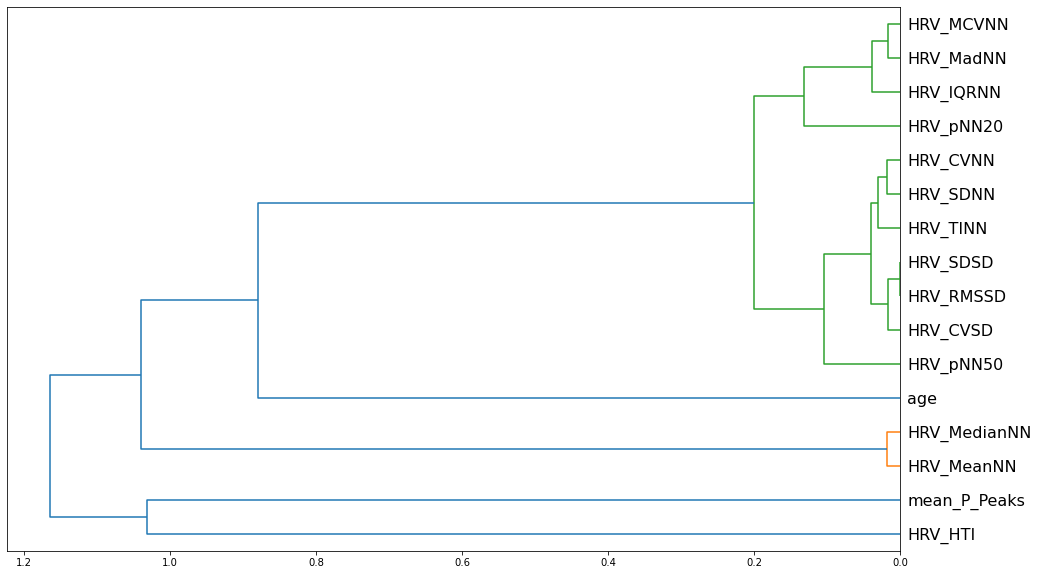

In [5]:
corr = np.round(scipy.stats.spearmanr(df_raw.drop('label',axis=1)).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_raw.drop('label',axis=1).columns, orientation='left', leaf_font_size=16)
plt.show()

Given that the variance can be obtained from the std, and viceversa it's no surprise they seem to provide the same information. Let's try and remove them.

In [6]:
to_drop = ['HRV_SDSD']
df_raw = df_raw.drop(to_drop, axis=1)

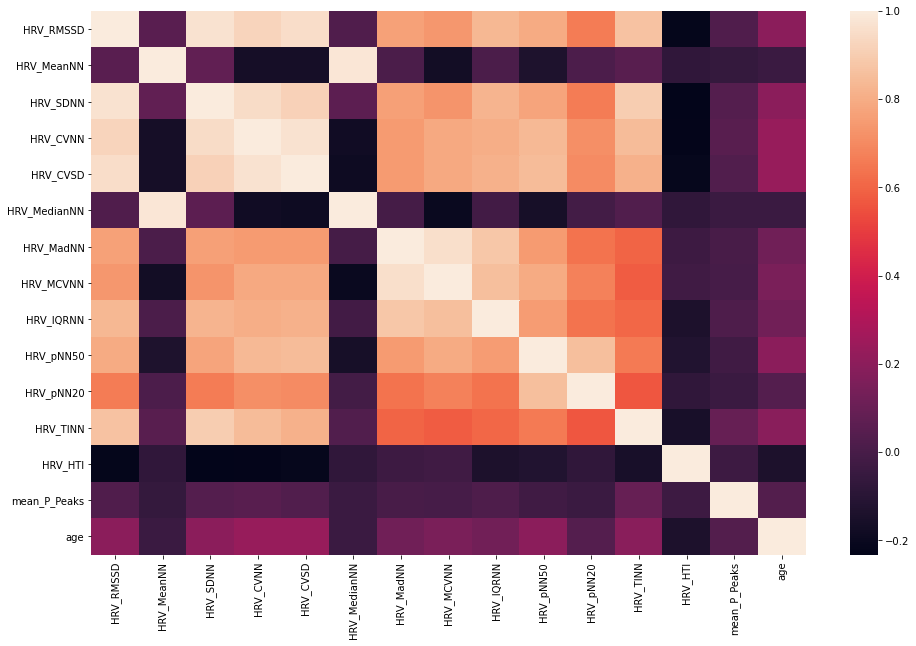

In [7]:
plt.figure(figsize=(16,10))
sns.heatmap(df_raw.corr())
plt.show()

### Renaming everything else as "Non-AF" in both sets

In [8]:
df_raw.loc[df_raw.label != 'AF', 'label'] = 'Non-AF'

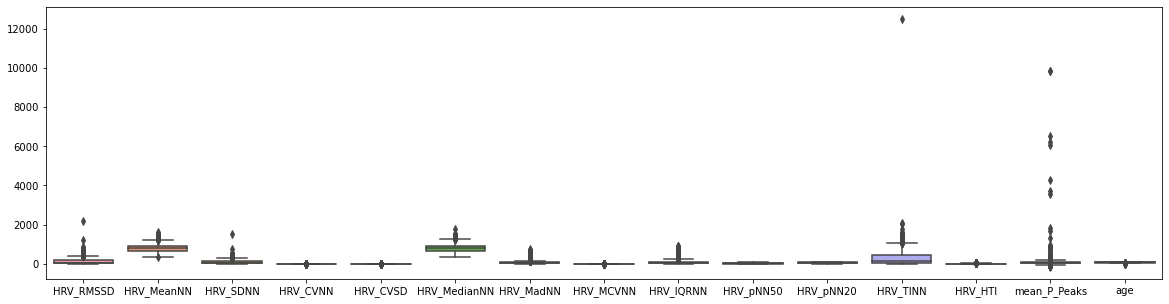

In [9]:
plt.figure(figsize=(20,5))
sns.boxplot(data=df_raw)
plt.show()

Seems to be an outlier so we'll remove that one from our dataset

In [10]:
df = df_raw.copy()
cols = df_raw.columns
cols = cols.drop('label')
for col in cols:
    df = df[df[col] < df[col].quantile(.99)]
    
df_raw = df.copy()

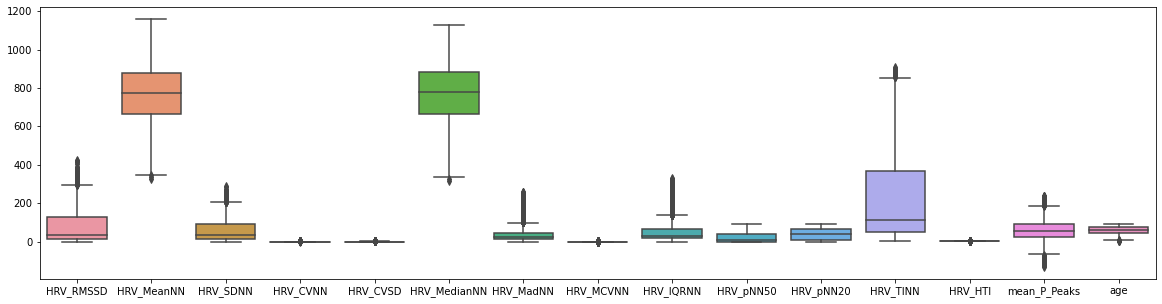

In [11]:
plt.figure(figsize=(20,5))
sns.boxplot(data=df_raw)
plt.show()

In [12]:
labels = pd.get_dummies(df_raw['label'])
labels.describe()

AF       Non-AF
count  5852.000000  5852.000000
mean      0.156015     0.843985
std       0.362901     0.362901
min       0.000000     0.000000
25%       0.000000     1.000000
50%       0.000000     1.000000
75%       0.000000     1.000000
max       1.000000     1.000000

## Split between Train and Validation Datasets

### Training Set (80%) - Validation (20%)

In [13]:
y = df_raw['label'].copy()
X = df_raw.drop('label', axis=1)
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=42)

## We check for missing values

In [14]:
df_raw.isnull().sum()

HRV_RMSSD       0
HRV_MeanNN      0
HRV_SDNN        0
HRV_CVNN        0
HRV_CVSD        0
HRV_MedianNN    0
HRV_MadNN       0
HRV_MCVNN       0
HRV_IQRNN       0
HRV_pNN50       0
HRV_pNN20       0
HRV_TINN        0
HRV_HTI         0
mean_P_Peaks    0
age             0
label           0
dtype: int64

## Evaluation Metrics

This are the evaluation metrics we are actually interested in.

In [15]:
res = pd.DataFrame({'model':[], 'f1':[]})

### We process our datasets and train our model

In [16]:
models = {
        'Logistic Regression': LogisticRegression(max_iter = 2000, n_jobs = 4, random_state=42),
        'Random Forest': RandomForestClassifier(n_jobs = 4, random_state=42),
        'SVC': SVC(random_state=42),
        'KNNeighbors': KNeighborsClassifier(n_jobs = 4)
}

ypreds = {}
sc = make_scorer(f1_score, pos_label='AF')

In [17]:
for name, model in models.items():
    
    scores = cross_val_score(model, X_train, y_train, cv=4, scoring=sc, n_jobs=4)
    model.fit(X_train, y_train)
    ypred = model.predict(X_eval)
    #f1 = f1_score(y_eval, ypred, pos_label='AF')
    ypreds[name] = ypred
    res = res.append({'model': f"{name}", 'f1': scores.mean()}, ignore_index=True)

In [18]:
res.sort_values('f1', ascending=False)

model        f1
1        Random Forest  0.905103
0  Logistic Regression  0.872326
3          KNNeighbors  0.865096
2                  SVC  0.862973

## Let's try a Standard Scaler

In [19]:
scal = StandardScaler()
xtrain_scal = scal.fit_transform(X_train)
xeval_scal = scal.transform(X_eval)

In [20]:
for name, model in models.items():
    scores = cross_val_score(model, xtrain_scal, y_train, cv=4, scoring=sc, n_jobs=4)
    model.fit(xtrain_scal, y_train)
    ypred = model.predict(xeval_scal)
    #f1 = f1_score(y_eval, ypred, pos_label='AF')
    ypreds[f'{name} Scal'] = ypred
    res = res.append({'model': f"{name} Scal", 'f1': scores.mean()}, ignore_index=True)

In [21]:
res.sort_values('f1', ascending=False)

model        f1
1             Random Forest  0.905103
5        Random Forest Scal  0.905103
6                  SVC Scal  0.893156
4  Logistic Regression Scal  0.878502
7          KNNeighbors Scal  0.875637
0       Logistic Regression  0.872326
3               KNNeighbors  0.865096
2                       SVC  0.862973

### Let's check and see if there's a polynomical relation between features

In [22]:
list(X_train.columns)

['HRV_RMSSD',
 'HRV_MeanNN',
 'HRV_SDNN',
 'HRV_CVNN',
 'HRV_CVSD',
 'HRV_MedianNN',
 'HRV_MadNN',
 'HRV_MCVNN',
 'HRV_IQRNN',
 'HRV_pNN50',
 'HRV_pNN20',
 'HRV_TINN',
 'HRV_HTI',
 'mean_P_Peaks',
 'age']

In [23]:
xpol_train = X_train.drop('age', axis=1)
xpol_eval = X_eval.drop('age', axis=1)

poly = PolynomialFeatures(2, include_bias=False)

xtrain_poly = poly.fit_transform(xpol_train)
xeval_poly = poly.transform(xpol_eval)

xtrain_poly = np.c_[xtrain_poly, X_train.age]
xeval_poly = np.c_[xeval_poly, X_eval.age]

scal = StandardScaler()
xtrain_poly = scal.fit_transform(xtrain_poly)
xeval_poly = scal.transform(xeval_poly)

In [24]:
for name, model in models.items():
    scores = cross_val_score(model, xtrain_poly, y_train, cv=4, scoring=sc, n_jobs=5)
    model.fit(xtrain_poly, y_train)
    ypred = model.predict(xeval_poly)
    #f1 = f1_score(y_eval, ypred, pos_label='AF')
    ypreds[f'{name} Poly'] = ypred
    res = res.append({'model': f"{name} Poly", 'f1': scores.mean()}, ignore_index=True)

In [25]:
res.sort_values('f1', ascending=False)

model        f1
1              Random Forest  0.905103
5         Random Forest Scal  0.905103
9         Random Forest Poly  0.893910
6                   SVC Scal  0.893156
10                  SVC Poly  0.885847
8   Logistic Regression Poly  0.884838
4   Logistic Regression Scal  0.878502
7           KNNeighbors Scal  0.875637
0        Logistic Regression  0.872326
11          KNNeighbors Poly  0.866097
3                KNNeighbors  0.865096
2                        SVC  0.862973

## We take a look at Principal Component Analysis

In [26]:
n_comps = X_train.shape[1]

pca = PCA(n_components = n_comps)

train_pca = pca.fit_transform(xtrain_scal)

eval_pca = pca.transform(xeval_scal)

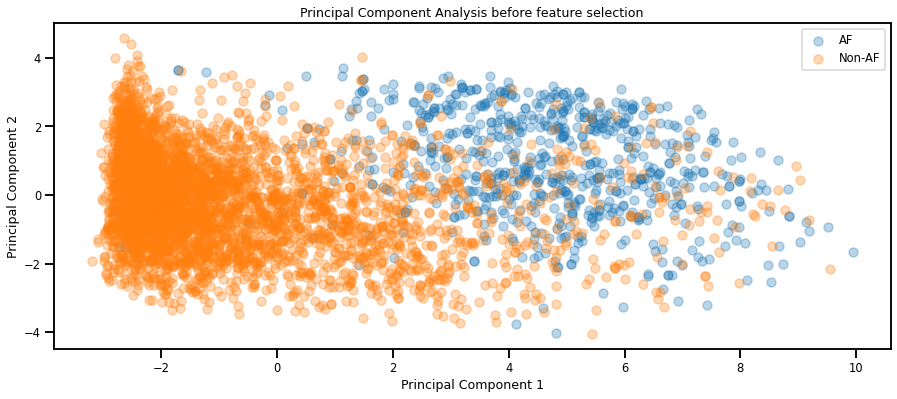

In [27]:
xpca = pd.DataFrame(train_pca)

sns.set_context("talk", font_scale=0.7)
plt.figure(figsize=(15,6))
plt.scatter(xpca.loc[(y_train == 'AF').ravel(),0],xpca.loc[(y_train == 'AF').ravel(),1], alpha = 0.3, label = 'AF')
plt.scatter(xpca.loc[(y_train == 'Non-AF').ravel(),0],xpca.loc[(y_train == 'Non-AF').ravel(),1], alpha = 0.3, label = 'Non-AF')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Principal Component Analysis before feature selection')
plt.legend(loc='upper right')
plt.show()

In [28]:
xpca.loc[(y_train == 'AF').ravel(), 'color'] = 'AF'
xpca.loc[(y_train == 'Non-AF').ravel(), 'color'] = 'Non-AF'

fig = px.scatter_3d(xpca, x=0, y=1, z=2, color='color', opacity=0.7)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [29]:
for name, model in models.items():
    scores = cross_val_score(model, train_pca, y_train, cv=4, scoring=sc, n_jobs=4)
    model.fit(train_pca, y_train)
    ypred = model.predict(eval_pca)
    #f1 = f1_score(y_eval, ypred, pos_label='AF')
    ypreds[f'{name} PCA'] = ypred
    res = res.append({'model': f"{name} PCA", 'f1': scores.mean()}, ignore_index=True)

In [30]:
res.sort_values('f1', ascending=False)

model        f1
1              Random Forest  0.905103
5         Random Forest Scal  0.905103
13         Random Forest PCA  0.894290
9         Random Forest Poly  0.893910
6                   SVC Scal  0.893156
14                   SVC PCA  0.893156
10                  SVC Poly  0.885847
8   Logistic Regression Poly  0.884838
4   Logistic Regression Scal  0.878502
12   Logistic Regression PCA  0.878502
7           KNNeighbors Scal  0.875637
15           KNNeighbors PCA  0.875637
0        Logistic Regression  0.872326
11          KNNeighbors Poly  0.866097
3                KNNeighbors  0.865096
2                        SVC  0.862973

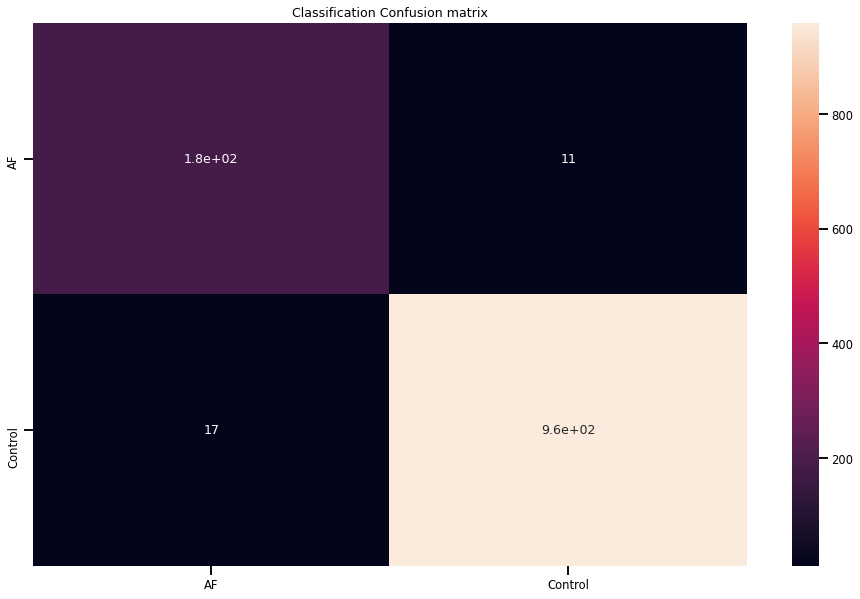

In [31]:
ypred = ypreds['Random Forest']

cm = confusion_matrix(y_eval, ypred)

df_cm = pd.DataFrame(cm, index = ['AF', 'Control'], columns = ['AF', 'Control'])
plt.figure(figsize = (16,10))
sns.heatmap(df_cm, annot=True)
plt.title('Classification Confusion matrix')
plt.show()

## Confidence based on Tree Variance

We take a look at the standard deviation among trees to see how confident we are about each classification. 

In [32]:
preds = np.stack([t.predict(eval_pca) for t in rf.estimators_])

NameError: name 'rf' is not defined

### We use the statistical Bootstrap Method

The bootstrap method is a popular non-parametric method, which does not require any distributional assumptions. Efron and Tibshirani provide a detailed review of the bootstrap method. The following is an algorithmic approach of obtaining a (1−α)100% percentile bootstrap conﬁdence interval for the population mean.

In [ ]:
from sklearn.utils import resample

n_iterations = 300
n_size = int(len(preds) * 0.60)

Lowers = []
Uppers = []

for i in range(len(preds[0])):
    
    means = []
    
    for _ in range(n_iterations):
        rs = resample(preds[:, i], n_samples=n_size, replace=True)
        means.append(np.mean(rs))
    
    alpha = 0.99
    p = ((1.0 - alpha) / 2.0) * 100
    lower = max(0.0, np.percentile(means, p))
    Lowers.append(lower)
    
    p = (alpha + ((1.0 - alpha) / 2.0)) * 100
    upper = min(1.0, np.percentile(means, p))
    Uppers.append(upper)

In [ ]:
y_eval = pd.Categorical(y_eval)
y = y_eval.codes

In [ ]:
X = pd.DataFrame(eval_pca)

X['actuals'] = y
X['preds'] = np.mean(preds, axis=0)
X['std'] = (np.std(preds, axis=0))
X['upper'] = Uppers - np.mean(preds, axis=0)
X['lower'] = np.mean(preds, axis=0) - Lowers
X['var'] = (np.var(preds, axis=0))
flds = ['actuals', 'preds', 'std', 'var', 'upper', 'lower']
X.loc[:5,flds]

### Predictions and intervals for the first 50 samples of the evaluation set

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Bar(
    name='Control',
    y=X['preds'][:50],
    error_y=dict(
            type='data',
            symmetric=False,
            array=X['upper'][:50],
            arrayminus=X['lower'][:50])))

fig.update_layout(shapes=[
    dict(type= 'line', yref='y', y0= 0.5, y1= 0.5, xref= 'x', x0= -1, x1= 50)])
fig.show()

### We analyze those the model seems to be sure about it's classification

Let's keep those where the prediction minus the lower limit error is above 0.9 and those where the prediction plus the upper limit error is below 0.1. 

In [ ]:
aux = X.loc[(X['preds'] - X['lower'] >= 0.7) | (X['preds'] + X['upper'] <= 0.3), flds]
a = np.array(aux.preds > 0.5)

aux['prediction'] = 0

aux.loc[aux.preds > 0.5, 'prediction'] = 1

f1_score(aux.actuals, aux.prediction, pos_label=0), len(aux), len(X), len(aux)/len(X)

#### It seems we can predict 87% of this set with a 98% chance of being correct.